#### Preliminaries - import main libraries

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import color, io, exposure, feature
from skimage.morphology import disk, diamond, square, opening, dilation, convex_hull_image
from skimage.morphology import remove_small_objects
from skimage.filters import  threshold_adaptive, threshold_otsu

from skimage.feature import corner_fast, corner_peaks, corner_orientations
from skimage.measure import find_contours, approximate_polygon

%matplotlib inline

#### Import test image

In [2]:
# import from url
#url = 'https://github.com/mycarta/rainbowbot/raw/master/test_f3_distorted_tet.ong'
#img = np.asarray(io.imread(url))[:,:,:3] # with removing alpha channel
img = np.asarray(io.imread('test_f3_distorted_text.png'))[:,:,:3]

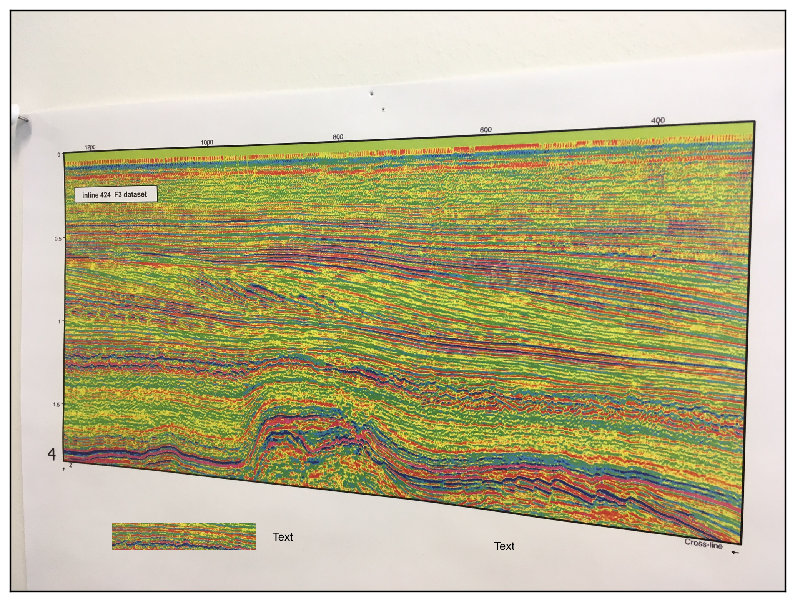

In [3]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(img,  interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 


#### Preporcessing

In [4]:
# Gray scal conversion and contrast stretching
gry = color.rgb2gray(img);
p2, p95 = np.percentile(gry, (2, 95))
rescale = exposure.rescale_intensity(gry, in_range=(p2, p95))

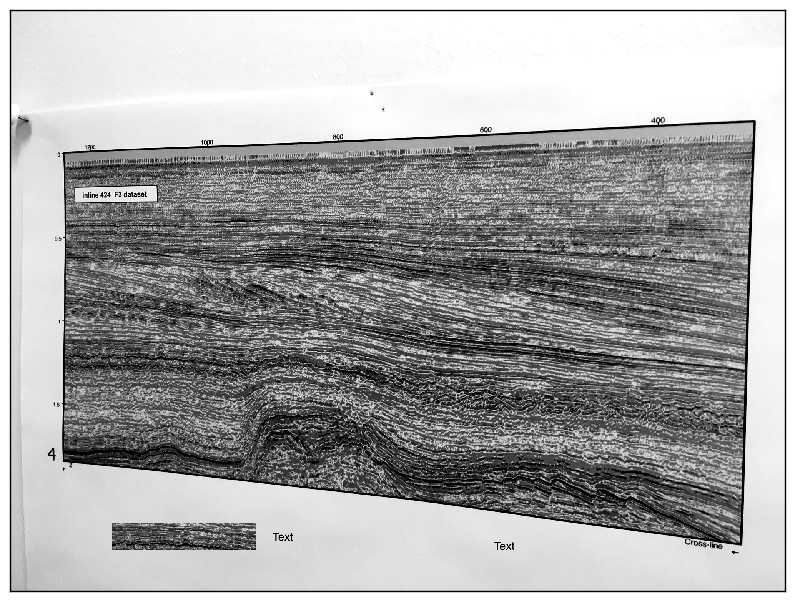

In [5]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(rescale,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Convert to binary 

In [6]:
global_thresh = threshold_otsu(rescale)
binary_global = rescale < global_thresh

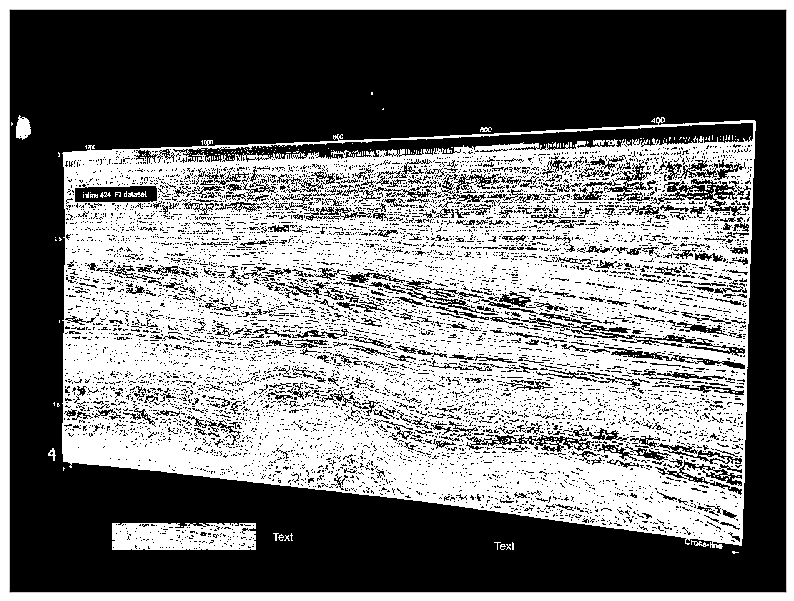

In [7]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_global,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Find the map

We want to eliminate both possibilities of ~black and ~nearly white border.

#### Get largest element in the binary image and use it as a mask for the original image

Detect largest bright element in the binary image. Making the assumption it would be the map.
Eliminate everything else (text, colorbar, holes, etc.).

In [8]:
# Label all white objects (made up of ones)
label_objects, nb_labels = ndi.label(binary_global) # ndimage.label actually labels 0 (background) as 0 and then 
                                                    # labels every nonzero object as 1, 2, ... n. 
    
# Calculate every labeled object's size. 
# np.bincount ignores whether input is an image or another type of array.
# It just calculates the binary sizes, including for the 0 (background).
sizes = np.bincount(label_objects.ravel())   

sizes[0] = 0    # This sets the size of the background to 0 so that if it happened to be larger than 
                # the largest white object it would not matter

# Keep only largest object
binary_objects = remove_small_objects(binary_global, max(sizes)) 

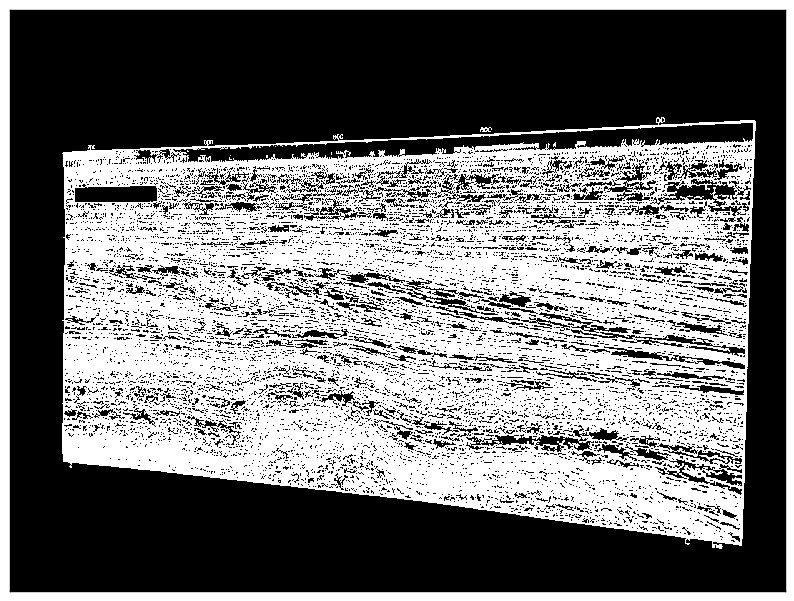

In [9]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_objects, cmap='gray',  interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('onlylargest.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [10]:
# Remove holes from it (black regions inside white object)
binary_holes = ndi.morphology.binary_fill_holes(binary_objects) 

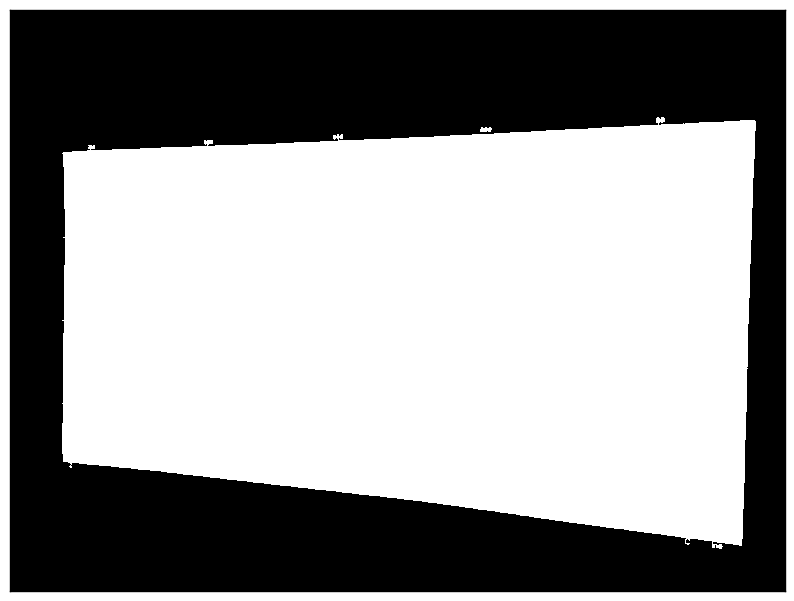

In [11]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_holes, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [12]:
enhanced = dilation(opening(binary_holes, disk(7)), square(7))

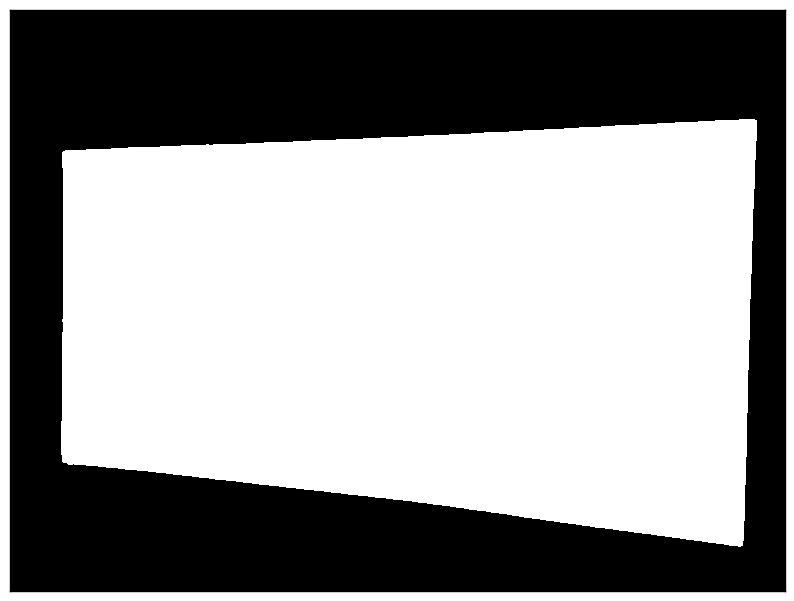

In [13]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Convex hull just in case ?

In [14]:
cnv = convex_hull_image(enhanced)

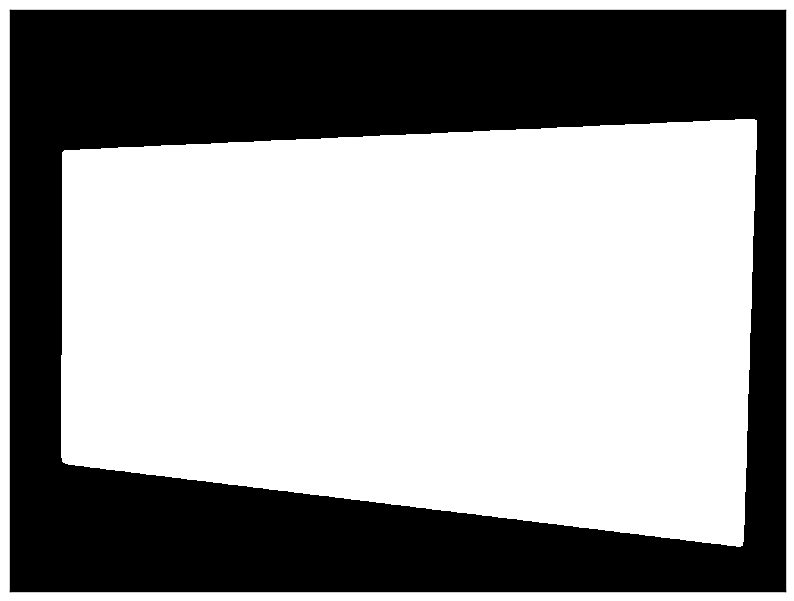

In [15]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cnv, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Find contour, corners and rectify

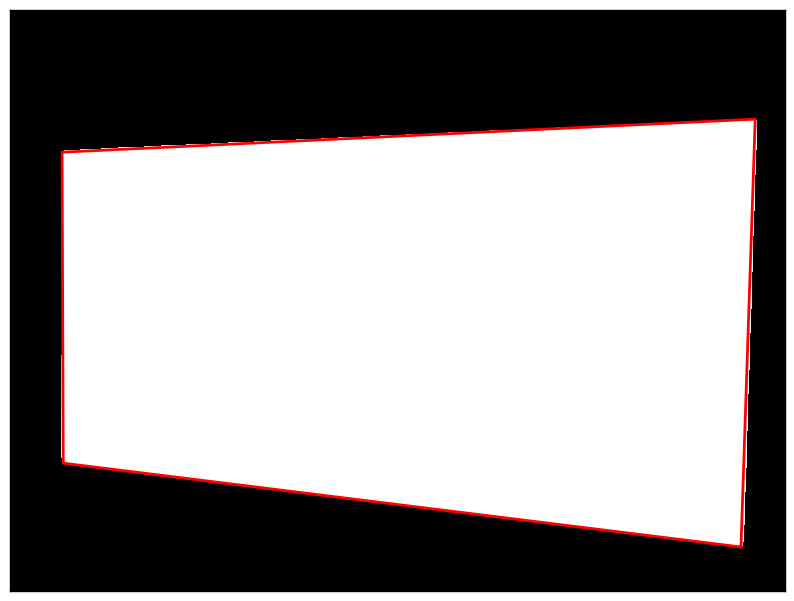

In [16]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cnv, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

for contour in find_contours(cnv, 0):
    coords = approximate_polygon(contour, tolerance=15)
    ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
plt.show()

#### Find and sort corners, define equivalent rectangle, rectify

In [ ]:
# corners = corner_peaks(corner_fast(img, 9), min_distance=1)